# CNN - сверточная нейронная сеть

Формула для свертки

---
## Вектор:
$$
o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1.
$$

---

## 📐 Формулы размера выхода при 2D-свёртке

Пусть:

| Символ | Обозначение |
|--------|-------------|
| `H`    | Высота входного изображения (число строк) |
| `W`    | Ширина входного изображения (число столбцов) |
| `K_h`  | Высота ядра (фильтра) — по вертикали |
| `K_w`  | Ширина ядра (фильтра) — по горизонтали |
| `P_h`  | Padding по высоте — число нулей сверху и снизу |
| `P_w`  | Padding по ширине — число нулей слева и справа |
| `S_h`  | Stride по высоте — шаг сдвига фильтра по вертикали |
| `S_w`  | Stride по ширине — шаг сдвига фильтра по горизонтали |
| `O_h`  | Высота выходного изображения |
| `O_w`  | Ширина выходного изображения |

---

## 🔢 Основные формулы:

$$
O_h = \left\lfloor \frac{H + 2P_h - K_h}{S_h} \right\rfloor + 1
$$

$$
O_w = \left\lfloor \frac{W + 2P_w - K_w}{S_w} \right\rfloor + 1
$$

---

## 💡 Частный случай — квадратные изображения и ядра:

Если $ H = W = n $, $ K_h = K_w = m $, $ P_h = P_w = p $, $ S_h = S_w = s $, то:

$$
o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1
$$

---

Действие `[*]` - это операция `floor`, она возвращает наиб. число для входного значения *, например `floor(1.77) -> [1.77] -> 1`

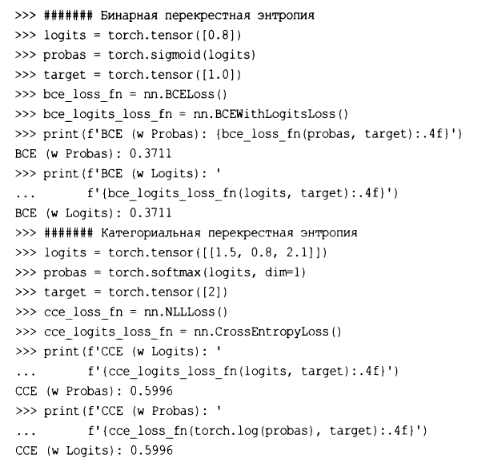

# Архитектура будущей сети
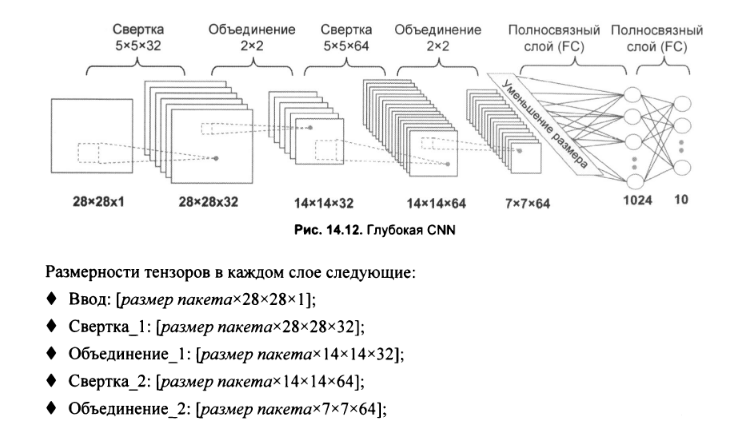

И последние полносвязанные слои <br>
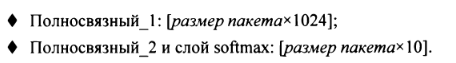

In [37]:
import torch
import torchvision

In [38]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [39]:
image_path = r'../.'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(image_path, train=True, transform=transform, download=False)

In [40]:
from torch.utils.data import Subset

In [41]:
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))    # Первые 10'000 записей
mnist_train_dataset= Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(image_path, train=False, transform=transform, download=False)

In [42]:
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=True)

test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=True)

# Создание модели MNIST

**Важно**, что слои *Conv2d* в *Pytorch* принимают данные в формате: `NCWH - number, channel, width, height`

In [43]:
import torch.nn as nn 

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
model = nn.Sequential()

## Сверточные слои Conv Layers
# Первый блок
# II: n, 1, 28, 28
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu', nn.ReLU())
model.add_module('pool', nn.MaxPool2d(kernel_size=2))
# OUT: n, 1, 14, 14 

# Второй блок
# IN: n, 1, 14, 14
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
# OUT: n, 1, 7, 7

# Слой расжатия
model.add_module('flatten', nn.Flatten())

## Полносвязные слои FullyConnected Layers
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=.5))   # DROPOUT layer
model.add_module('fc2', nn.Linear(1024, 10))

model = model.to(device)

In [60]:
loss_fn = nn.CrossEntropyLoss()    # nn.CrossEntropyLoss() уже содержит softmax()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

## Обучение

In [ ]:
def train_model(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()    # Перевожу в режим обучения
        
        for x_batch, y_batch in train_dl:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(x_batch)    # return probas
            loss = loss_fn(pred, y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
            
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()    # Перевожу в режим оценки
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)    # return probas
                loss = loss_fn(pred, y_batch)
                
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'{epoch+1}/{num_epochs}, train_accuracy: {accuracy_hist_train[epoch]:.3f}, train_loss: {loss_hist_train[epoch]:.3f}, valid_accuracy: {accuracy_hist_valid[epoch]:.3f}, valid_loss: {loss_hist_valid[epoch]:.3f}')
    
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
            
    

In [62]:
torch.manual_seed(1)
num_epochs = 20
hist = train_model(model, num_epochs, train_dl, valid_dl)

1 epoch, train_accuracy: 0.953, train_loss: 0.150,
 valid_accuracy: 0.983, valid_loss: 0.059
2 epoch, train_accuracy: 0.985, train_loss: 0.046,
 valid_accuracy: 0.986, valid_loss: 0.048
3 epoch, train_accuracy: 0.990, train_loss: 0.032,
 valid_accuracy: 0.989, valid_loss: 0.036
4 epoch, train_accuracy: 0.992, train_loss: 0.026,
 valid_accuracy: 0.988, valid_loss: 0.041
5 epoch, train_accuracy: 0.994, train_loss: 0.020,
 valid_accuracy: 0.989, valid_loss: 0.039
6 epoch, train_accuracy: 0.994, train_loss: 0.018,
 valid_accuracy: 0.990, valid_loss: 0.034
7 epoch, train_accuracy: 0.996, train_loss: 0.013,
 valid_accuracy: 0.991, valid_loss: 0.037
8 epoch, train_accuracy: 0.996, train_loss: 0.013,
 valid_accuracy: 0.989, valid_loss: 0.047
9 epoch, train_accuracy: 0.997, train_loss: 0.010,
 valid_accuracy: 0.991, valid_loss: 0.039
10 epoch, train_accuracy: 0.997, train_loss: 0.011,
 valid_accuracy: 0.991, valid_loss: 0.040
11 epoch, train_accuracy: 0.997, train_loss: 0.009,
 valid_accuracy: 

## Оценка модели

In [64]:
import matplotlib.pyplot as plt
import numpy as np

In [79]:
accuracy_hist_train_cpu, accuracy_hist_valid_cpu = zip(*[(t1.cpu(), t2.cpu()) for t1, t2 in zip(hist[2], hist[3])])

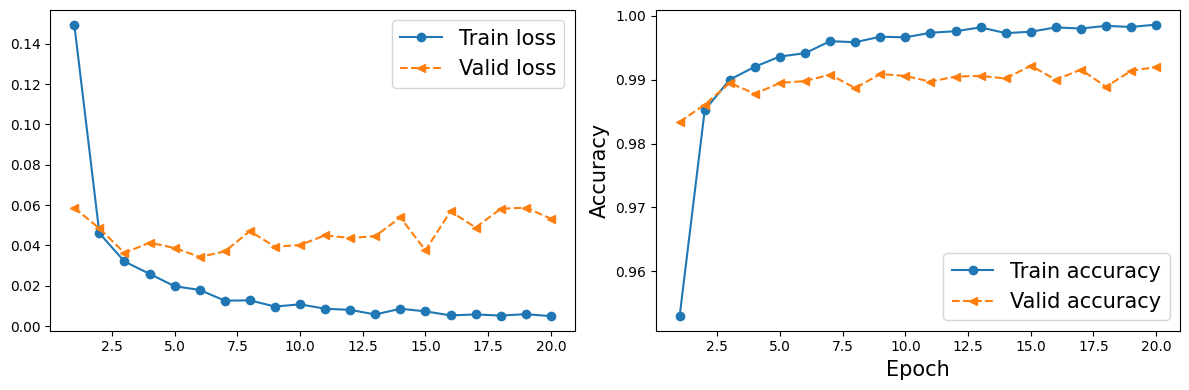

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Valid loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, accuracy_hist_train_cpu, '-o', label='Train accuracy')
ax.plot(x_arr, accuracy_hist_valid_cpu, '--<', label='Valid accuracy')
ax.legend(fontsize=15)

ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.tight_layout()
plt.show()

[tensor(0.9530, device='cuda:0'),
 tensor(0.9852, device='cuda:0'),
 tensor(0.9900, device='cuda:0'),
 tensor(0.9920, device='cuda:0'),
 tensor(0.9936, device='cuda:0'),
 tensor(0.9942, device='cuda:0'),
 tensor(0.9960, device='cuda:0'),
 tensor(0.9959, device='cuda:0'),
 tensor(0.9967, device='cuda:0'),
 tensor(0.9966, device='cuda:0'),
 tensor(0.9974, device='cuda:0'),
 tensor(0.9976, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9973, device='cuda:0'),
 tensor(0.9975, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9980, device='cuda:0'),
 tensor(0.9984, device='cuda:0'),
 tensor(0.9983, device='cuda:0'),
 tensor(0.9986, device='cuda:0')]

# Распознавание улыбок

In [1]:
import os
image_path = 'celeba'
image_path

'celeba'

In [2]:
os.listdir(image_path)

['.DS_Store',
 'list_bbox_celeba.txt',
 'list_eval_partition.txt',
 'img_align_celeba',
 'list_attr_celeba.txt',
 'img_align_celeba.zip',
 'list_landmarks_align_celeba.txt',
 'identity_CelebA.txt',
 'list_landmarks_celeba.txt']

In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

In [4]:
# celeba_train_ds = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
# celeba_valid_ds = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
# celeba_test_ds = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset

In [5]:
from PIL import Image as PILImage

In [6]:
with open(os.path.join(image_path, 'list_attr_celeba.txt'), 'r') as f:
    file = f.readlines() 
    sample = int(file[0])
    classes = file[1].split(' ')
    classes.pop(-1)
    attr = []
    
    for i in file[2:]:
        list_ = i.split()
        list_.pop(0)
        list_ = list(map(int, list_))
        attr.append(list_)

In [7]:
for li in attr:
    for idx in range(len(li)):
        if li[idx] == -1: li[idx] = 0

In [8]:
with open(os.path.join(image_path, 'list_eval_partition.txt'), 'r') as f:
    file = f.readlines() 
    eval_dict = {
        'name': [],
        'eval': []
    }
    
    for i in file:
        k, v = i.split()
        eval_dict['name'].append(k)
        eval_dict['eval'].append(int(v))

In [9]:
with open(os.path.join(image_path, 'list_landmarks_align_celeba.txt'), 'r') as f:
    file = f.readlines() 
    landmark_align = file[1].split()
    landmark_align_cor = []
    
    for fi in file[2:]:
        li = list(map(int, fi.split()[1:]))
        landmark_align_cor.append(li)

In [49]:
landmark_align_cor

[[69, 109, 106, 113, 77, 142, 73, 152, 108, 154],
 [69, 110, 107, 112, 81, 135, 70, 151, 108, 153],
 [76, 112, 104, 106, 108, 128, 74, 156, 98, 158],
 [72, 113, 108, 108, 101, 138, 71, 155, 101, 151],
 [66, 114, 112, 112, 86, 119, 71, 147, 104, 150],
 [71, 111, 106, 110, 94, 131, 74, 154, 102, 153],
 [70, 112, 108, 111, 85, 135, 72, 152, 104, 152],
 [71, 110, 106, 111, 84, 137, 73, 155, 104, 153],
 [68, 113, 110, 111, 97, 139, 66, 152, 109, 150],
 [68, 111, 108, 112, 89, 136, 70, 151, 107, 151],
 [69, 112, 108, 111, 89, 139, 72, 152, 104, 151],
 [69, 112, 108, 112, 89, 136, 68, 150, 109, 152],
 [68, 112, 109, 111, 90, 138, 67, 151, 109, 150],
 [68, 112, 109, 111, 92, 141, 72, 150, 104, 152],
 [69, 110, 107, 112, 90, 133, 74, 152, 105, 153],
 [69, 112, 108, 111, 85, 138, 70, 152, 105, 152],
 [67, 112, 109, 113, 86, 138, 67, 150, 111, 151],
 [67, 112, 110, 112, 88, 135, 68, 150, 109, 150],
 [68, 111, 108, 112, 88, 134, 73, 152, 104, 151],
 [69, 112, 109, 110, 86, 125, 72, 152, 103, 151],

In [10]:
eval_dict['name'][190611], eval_dict['eval'][190611]

('190612.jpg', 2)

In [11]:
import numpy as np

In [12]:
train_files = [el for el in list(zip(eval_dict['name'], eval_dict['eval']))]

In [13]:
len(train_files)

202599

In [14]:
images_dir = os.path.join(image_path, 'img_align_celeba')
images_dir

'celeba/img_align_celeba'

In [15]:
train_files, train_labels = zip(*[(os.path.join(images_dir, el[0]), el[1]) for el in train_files])

In [16]:
train_files, train_labels

(('celeba/img_align_celeba/000001.jpg',
  'celeba/img_align_celeba/000002.jpg',
  'celeba/img_align_celeba/000003.jpg',
  'celeba/img_align_celeba/000004.jpg',
  'celeba/img_align_celeba/000005.jpg',
  'celeba/img_align_celeba/000006.jpg',
  'celeba/img_align_celeba/000007.jpg',
  'celeba/img_align_celeba/000008.jpg',
  'celeba/img_align_celeba/000009.jpg',
  'celeba/img_align_celeba/000010.jpg',
  'celeba/img_align_celeba/000011.jpg',
  'celeba/img_align_celeba/000012.jpg',
  'celeba/img_align_celeba/000013.jpg',
  'celeba/img_align_celeba/000014.jpg',
  'celeba/img_align_celeba/000015.jpg',
  'celeba/img_align_celeba/000016.jpg',
  'celeba/img_align_celeba/000017.jpg',
  'celeba/img_align_celeba/000018.jpg',
  'celeba/img_align_celeba/000019.jpg',
  'celeba/img_align_celeba/000020.jpg',
  'celeba/img_align_celeba/000021.jpg',
  'celeba/img_align_celeba/000022.jpg',
  'celeba/img_align_celeba/000023.jpg',
  'celeba/img_align_celeba/000024.jpg',
  'celeba/img_align_celeba/000025.jpg',


In [17]:
train_files = np.array(train_files)
train_labels = np.array(train_labels).astype(np.int32)

In [18]:
train_files, train_labels

(array(['celeba/img_align_celeba/000001.jpg',
        'celeba/img_align_celeba/000002.jpg',
        'celeba/img_align_celeba/000003.jpg', ...,
        'celeba/img_align_celeba/202597.jpg',
        'celeba/img_align_celeba/202598.jpg',
        'celeba/img_align_celeba/202599.jpg'],
       shape=(202599,), dtype='<U34'),
 array([0, 0, 0, ..., 2, 2, 2], shape=(202599,), dtype=int32))

In [19]:
len(train_files)

202599

In [20]:
train_files[0], type(train_files[0]), train_labels[0], type(train_labels[0])

(np.str_('celeba/img_align_celeba/000001.jpg'),
 numpy.str_,
 np.int32(0),
 numpy.int32)

In [21]:
np.unique(train_labels)

array([0, 1, 2], dtype=int32)

# Создание Dataset

In [22]:
class Myceleba_ds(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
           
    def __getitem__(self, index):
        img = PILImage.open(self.file_list[index])
        if self.transform: img = self.transform(img)
        label = self.labels[index]
            
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [25]:
train_ds = Myceleba_ds(train_files, train_labels)

In [26]:
train_ds[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>, np.int32(0))

# Транформация объектов

## Crop

In [23]:
import matplotlib.pyplot as plt

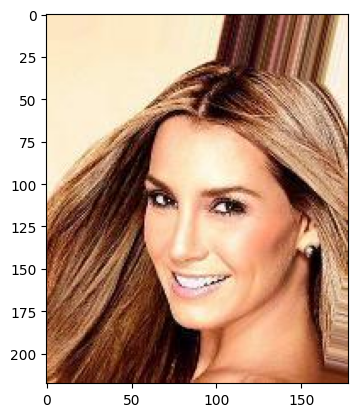

In [27]:
img, label = train_ds[0]
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
plt.imshow(img)

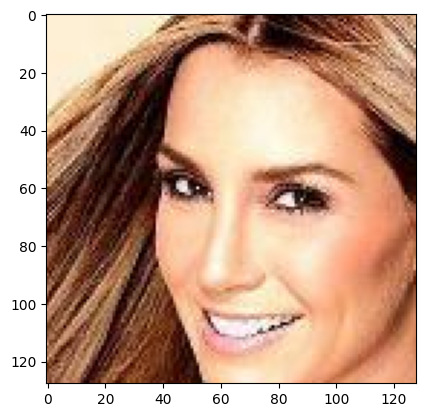

In [24]:
plt.imshow(img_cropped)

## Отражение по горизонтали

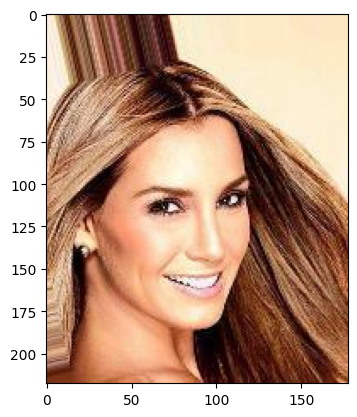

In [25]:
img, label = train_ds[0]
img_hflipped = transforms.functional.hflip(img)
plt.imshow(img_hflipped)

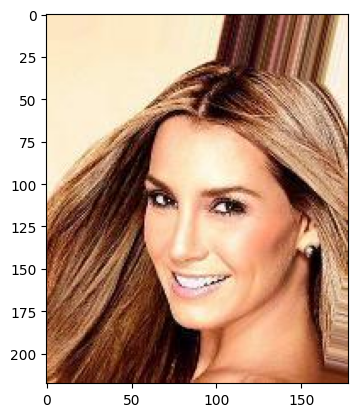

In [26]:
plt.imshow(img)

## Изменение контраста

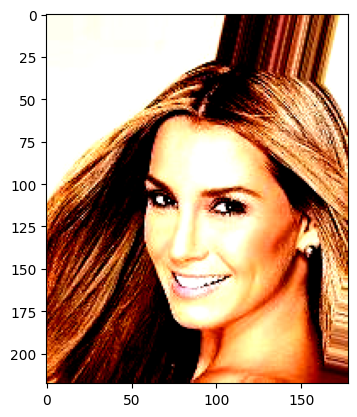

In [27]:
img, label = train_ds[0]
img_transfromed = transforms.functional.adjust_contrast(img, contrast_factor=2)
plt.imshow(img_transfromed)

## Изменение яркости

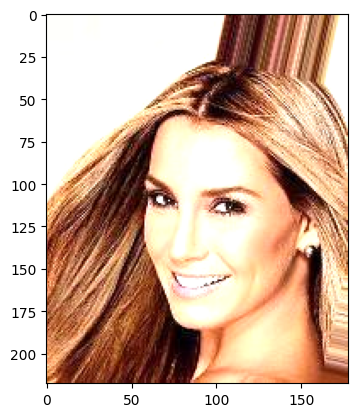

In [28]:
img, label = train_ds[0]
img_transfromed = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
plt.imshow(img_transfromed)

## Обрезка относительно центра

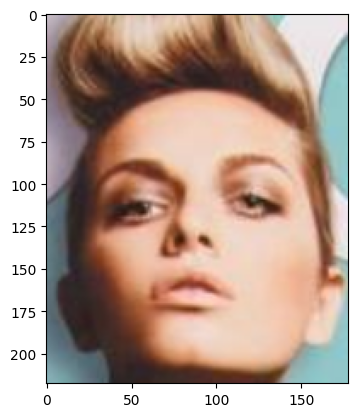

In [29]:
img, label = train_ds[4]
img_center_crop = transforms.functional.center_crop(img, [.7*218, .7*178])
img_resized = transforms.functional.resize(img_center_crop, size=[218, 178])
plt.imshow(img_resized)

# Обучение модели

## Берем только 16000 экз. для обучения и 1000 для теста

In [28]:
train_transform = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

valid_trasform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

In [29]:
train_files[:5], train_labels[:5]

(array(['celeba/img_align_celeba/000001.jpg',
        'celeba/img_align_celeba/000002.jpg',
        'celeba/img_align_celeba/000003.jpg',
        'celeba/img_align_celeba/000004.jpg',
        'celeba/img_align_celeba/000005.jpg'], dtype='<U34'),
 array([0, 0, 0, 0, 0], dtype=int32))

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_x, valid_x, train_y, valid_y = train_test_split(train_files, train_labels, train_size=16000, test_size=1000, stratify=train_labels, random_state=228)

In [32]:
train_ds = Myceleba_ds(train_x, torch.from_numpy(train_y).float(), train_transform)
valid_ds = Myceleba_ds(valid_x, torch.from_numpy(valid_y).float(), valid_trasform)

In [33]:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True)

In [34]:
next(iter(train_dl))[0]

tensor([[[[0.9804, 0.9765, 0.9765,  ..., 0.8510, 0.8588, 0.8588],
          [0.9804, 0.9843, 0.9843,  ..., 0.8392, 0.8549, 0.8510],
          [0.9804, 0.9843, 0.9843,  ..., 0.8392, 0.8510, 0.8510],
          ...,
          [0.9373, 0.9333, 0.9373,  ..., 0.0471, 0.0549, 0.0471],
          [0.9373, 0.9333, 0.9333,  ..., 0.0353, 0.0431, 0.0431],
          [0.9333, 0.9333, 0.9412,  ..., 0.0314, 0.0353, 0.0471]],

         [[0.9647, 0.9608, 0.9608,  ..., 0.8275, 0.8353, 0.8353],
          [0.9647, 0.9686, 0.9686,  ..., 0.8157, 0.8314, 0.8275],
          [0.9647, 0.9686, 0.9686,  ..., 0.8196, 0.8314, 0.8314],
          ...,
          [0.9216, 0.9176, 0.9216,  ..., 0.0510, 0.0510, 0.0588],
          [0.9216, 0.9176, 0.9137,  ..., 0.0392, 0.0431, 0.0471],
          [0.9176, 0.9137, 0.9137,  ..., 0.0392, 0.0431, 0.0471]],

         [[0.9529, 0.9490, 0.9490,  ..., 0.8275, 0.8353, 0.8353],
          [0.9529, 0.9569, 0.9569,  ..., 0.8118, 0.8275, 0.8275],
          [0.9529, 0.9569, 0.9569,  ..., 0

In [35]:
next(iter(train_dl))[1]

tensor([0., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])

In [36]:
len(train_ds), len(valid_ds)

(16000, 1000)

In [37]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('mpool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=.5))

model.add_module('conv2', nn.Conv2d(32, 64, 3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('mpool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=.5))

model.add_module('conv3', nn.Conv2d(64, 128, 3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('mpool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(128, 256, 3, padding=1))
model.add_module('relu4', nn.ReLU())

In [38]:
x = torch.ones([4, 3, 64, 64])
model(x).shape

torch.Size([4, 256, 8, 8])

In [39]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

In [40]:
x = torch.ones([4, 3, 64, 64])
model(x).shape

torch.Size([4, 256])

In [41]:
model.add_module('fc1', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

In [42]:
x = torch.ones([4, 3, 64, 64])
model(x).shape

torch.Size([4, 1])

In [43]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (mpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (mpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [44]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
model = model.to(device)

## Функция для обучения

In [47]:
def train_model(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(x_batch)[:, 0]
            
            loss = loss_fn(pred, y_batch)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
            
        print(f'{epoch+1}/{num_epochs}, train_accuracy: {accuracy_hist_train[epoch]:.4f}, train_loss: {loss_hist_train[epoch]:.4f}, valid_accuracy: {accuracy_hist_valid[epoch]:.4f}, valid_loss: {loss_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
                

In [48]:
torch.manual_seed(1)
num_epochs = 30
hist = train_model(model, num_epochs, train_dl, valid_dl)

/pytorch/aten/src/ATen/native/cuda/Loss.cu:91: operator(): block: [0,0,0], thread: [12,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:91: operator(): block: [0,0,0], thread: [22,0,0] Assertion `target_val >= zero && target_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:91: operator(): block: [0,0,0], thread: [23,0,0] Assertion `target_val >= zero && target_val <= one` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
accuracy_hist_train_cpu, accuracy_hist_valid_cpu = zip(*[(t1.cpu(), t2.cpu()) for t1, t2 in zip(hist[2], hist[3])])

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Valid loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, accuracy_hist_train_cpu, '-o', label='Train accuracy')
ax.plot(x_arr, accuracy_hist_valid_cpu, '--<', label='Valid accuracy')
ax.legend(fontsize=15)

ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.tight_layout()
plt.show()